# Import Data

In [1]:
#Import stuff
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
from sklearn.neighbors import DistanceMetric
import warnings
import gower
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import inspect
import matplotlib.pyplot as plt
from sklearn import metrics
from keras import backend as K
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn import tree
    

def recall_m(y_true, y_pred): # TPR
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # P
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # TP + FP
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_m2(y_true, y_pred):
    return f1_score(y_true, y_pred)
    #precision = precision_m(y_true, y_pred)
    #recall = recall_m(y_true, y_pred)
    #return 2*((precision*recall)/(precision+recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n

In [2]:
import tensorflow as tf

In [3]:
#accuracy after each batch
class BCP(tf.keras.callbacks.Callback):
    batch_accuracy = [] # accuracy at given batch
    batch_f1 = [] # f1 at given batch
    
    def __init__(self):
        super(BCP,self).__init__() 
        
    def on_train_batch_end(self, batch, logs=None):
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_f1.append(logs.get('f1_m'))
        


In [4]:
#accuracy after each batch
class BCP2(tf.keras.callbacks.Callback):
    batch_accuracy = [] # accuracy at given batch
    batch_f1 = [] # f1 at given batch
    batch_f1_val = [] # f1 of validation at given batch
    
    def __init__(self, val_data):
        super(BCP,self).__init__() 
        self.validation_data = val_data
        
    def on_train_batch_end(self, batch, logs=None):
        x_val = self.validation_data[0]
        y_val_true = self.validation_data[1]
        y_val_pred = self.model.predict(x_val, verbose=0)
        
        print(vars(self))
        print(vars(batch))
        print(vars(logs))
        
        y_val_class = [0 if val < .5 else 1 for val in y_val_pred]
        batchF1 = f1_m2(y_val_true, y_val_class)
        
        BCP.batch_f1_val.append(batchF1)
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_f1.append(logs.get('f1_m'))

In [5]:
def evalNN(thresh, pred, ytest):
    plotROC(pred, ytest)
    classPred = [0 if val < thresh else 1 for val in pred]
    evaluate(ytest, classPred)

def thresh(pred, ytest):
    bestacc = 0
    besttp = 0
    bestf1 = 0
    bestthresh = 0
    accList = []
    tpList = []
    f1list = []
    threshlist = []
    for i in range(1,100):
        classPred = [0 if val < (i/100) else 1 for val in pred]
        accuracy = accuracy_score(ytest, classPred)
        tpr = recall_score(ytest, classPred)
        f1 = f1_score(ytest, classPred)
        accList.append(accuracy)
        tpList.append(tpr)
        f1list.append(f1)
        threshlist.append(i)
        if (f1>bestf1):
            bestacc= accuracy
            besttp = tpr
            bestf1 = f1
            bestthresh=i
            
    plt.plot(threshlist, accList, 'b', label='Accuracy')
    plt.plot(threshlist, tpList, 'r', label='Recall')
    plt.plot(threshlist, f1list, 'g', label='F1 score')
    plt.axvline(x = bestthresh, color = 'k', label = 'Best threshold')
    plt.title('Threshold Graph')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()

    return (bestthresh/100)

def plotNN(history):
    # Extract accuracy and TPR values from the training history
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    epochs = range(1, len(accuracy) + 1)

    # Plot the accuracy values
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    
    # Plot the recall values
    plt.plot(epochs, f1, 'k', label='Training f1')
    plt.plot(epochs, val_f1, 'c', label='Validation f1')

    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()

def NN(df, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])
    
    xtrain = df.drop("Churn_Yes", axis=1)
    ytrain = df["Churn_Yes"]
    
    BCP.batch_accuracy.clear()
    BCP.batch_f1.clear()
    
    val_data = (xtest, ytest)
    
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=False, 
                        validation_data=val_data, callbacks = [BCP()], verbose=0)
    
    plt.plot(range(len(BCP.batch_f1)), BCP.batch_f1, 'r', label='F1')
    plt.title('Batch F1 Graph')
    plt.xlabel('Batch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()
    
    plotNN(history)
    
    print("########################   TRAIN   ########################")
    pred = model.predict(xtrain)
    threshold = thresh(pred, ytrain)
    evalNN(threshold, pred, ytrain)
    
    
    print("\n\n\n########################   TEST   ########################")
    pred = model.predict(xtest)
    evalNN(threshold, pred, ytest)
    
def NNSH(df, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])
    
    xtrain = df.drop("Churn_Yes", axis=1)
    ytrain = df["Churn_Yes"]
    
    BCP.batch_accuracy.clear()
    BCP.batch_f1.clear()
    
    val_data = (xtest, ytest)
    
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, 
                        validation_data=val_data, callbacks = [BCP()], verbose=0)
    
    plt.plot(range(len(BCP.batch_f1)), BCP.batch_f1, 'r', label='F1')
    plt.title('Batch F1 Graph')
    plt.xlabel('Batch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()
    
    plotNN(history)
    print("########################   TRAIN   ########################")
    pred = model.predict(xtrain)
    threshold = thresh(pred, ytrain)
    evalNN(threshold, pred, ytrain)
    
    
    print("\n\n\n########################   TEST   ########################")
    pred = model.predict(xtest)
    evalNN(threshold, pred, ytest)
    
def plotROC(prob, ytest):
    fpr, tpr, _ = metrics.roc_curve(ytest,  prob)
    auc = metrics.roc_auc_score(ytest, prob)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.title('ROC and AUC')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
def findClosest(num):
    i = (notSBD['Prob'] - num).abs().idxmin()
    row = notSBD.loc[i]
    notSBD.drop(i, inplace=True)
    return row

def evaluate(acc, pred, bestthresh):
    cm = confusion_matrix(acc, pred)
    bestacc = accuracy_score(acc, pred)
    besttp = recall_score(acc, pred)
    bestf1 = f1_score(acc, pred)
    
    print("Confusion Matrix:")
    print(cm)
    print("Best Threshold:", bestthresh)
    print("Accuracy:", bestacc)
    print("Recall:", besttp)
    print("F1:", bestf1)


    

def dist(df):
    yes = len(df[df["Churn_Yes"] == 1])
    no = len(df[df["Churn_Yes"] == 0])
    print("Churn Yes:", yes)
    print("Churn No:", no)
    return (yes, no)

In [6]:
#read data
churn = pd.read_csv(r"C:\Users\21sla\OneDrive - Dickinson College\Data300\WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Before:", len(churn))
churn = churn.dropna(how= 'any', axis=0)
print("After:", len(churn))
#churn.head(5)
churn.dtypes

Before: 7043
After: 7043


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
#Drop ID
clean = churn.drop("customerID", axis=1)

#Remove missing values
clean.replace(' ', np.nan, inplace=True)
print("Before:", len(clean))
clean = clean.dropna(how= 'any', axis=0)
print("After:", len(clean))

#set data types
clean["TotalCharges"] = clean["TotalCharges"].astype(float)
clean["SeniorCitizen"] = clean["SeniorCitizen"].astype(object)


Before: 7043
After: 7032


In [8]:
#Make dummies
dummies = pd.get_dummies(clean, drop_first= True)
clean = dummies
clean.dtypes

C:\Users\21sla\AppData\Local\Temp\ipykernel_5088\4219534775.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummies = pd.get_dummies(clean, drop_first= True)


tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                uint8
SeniorCitizen_1                            uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

# Log Model

In [9]:
x = clean.drop('Churn_Yes', axis=1)
y = clean['Churn_Yes']

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


In [11]:
xtrain.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6030,43,49.05,2076.20,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
3410,3,53.40,188.70,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
5483,55,77.75,4458.15,0,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
5524,45,54.65,2553.70,1,0,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6337,55,100.90,5448.60,0,0,1,1,1,0,1,...,0,1,0,1,1,0,0,0,0,1


In [12]:
xtest.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2481,61,25.00,1501.75,1,1,1,0,1,0,1,...,1,0,1,0,0,1,0,0,0,0
6784,19,24.70,465.85,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,0,0
6125,13,102.25,1359.00,1,0,1,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
3052,37,55.05,2030.75,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
4099,6,29.45,161.45,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Training 
model = LogisticRegression(max_iter=1000)
model.fit(xtrain, ytrain)

LogisticRegression(max_iter=1000)

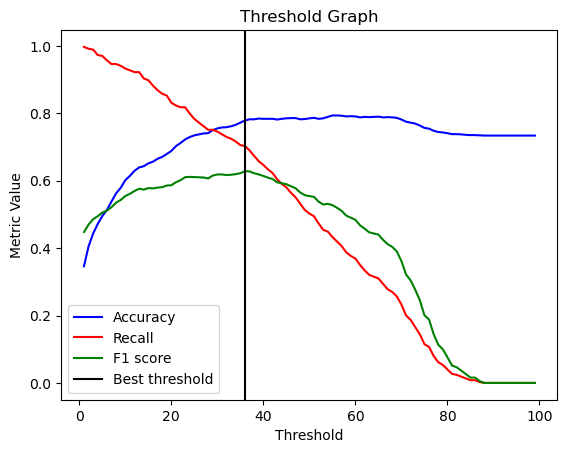

In [14]:
#Getting probabilities
yprob = model.predict_proba(xtest)
threshold = thresh(yprob[:, 1], ytest)
#threshold = 0.5
ypred = (yprob[:, 1] > threshold).astype(int)

In [15]:
#Log results
evaluate(ytest,ypred, threshold)

Confusion Matrix:
[[833 200]
 [111 263]]
Best Threshold: 0.36
Accuracy: 0.7789623312011372
Recall: 0.7032085561497327
F1: 0.6284348864994026


# Oversample

In [16]:
fittedProb = model.predict_proba(xtrain)[:, 1]

In [17]:
fittedClass = (fittedProb > threshold).astype(int)
probdf = xtrain.copy()
probdf["Churn_Yes"] = ytrain
probdf["Prob"] = fittedProb
probdf["Class"] = fittedClass


In [18]:
evaluate(ytrain,fittedClass, threshold)

Confusion Matrix:
[[3374  756]
 [ 447 1048]]
Best Threshold: 0.36
Accuracy: 0.7861333333333334
Recall: 0.7010033444816054
F1: 0.6353440436495907


In [19]:
misses = probdf[probdf["Churn_Yes"] != probdf["Class"]]
len(misses)

1203

In [20]:
###Simple oversample###

class1 = probdf[probdf["Churn_Yes"] == 1]
distribution = dist(probdf)

oversample = class1.sample(n=(distribution[1]-distribution[0]), replace = True)

overDf = pd.concat([probdf, oversample], ignore_index=True)

dist(overDf)

Churn Yes: 1495
Churn No: 4130
Churn Yes: 4130
Churn No: 4130


(4130, 4130)

In [21]:
###Oversample misses###

missDf = pd.concat([probdf, misses], ignore_index=True)
len(missDf)


6828

In [22]:
probdf.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,Prob,Class
6030,43,49.05,2076.20,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0.249405,0
3410,3,53.40,188.70,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0.391491,1
5483,55,77.75,4458.15,0,0,1,0,1,0,1,...,0,0,0,1,0,1,0,1,0.271655,0
5524,45,54.65,2553.70,1,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0.012312,0
6337,55,100.90,5448.60,0,0,1,1,1,0,1,...,1,1,0,0,0,0,1,0,0.122815,0


In [23]:
###Hybrid###

missedClass1 = misses[misses["Churn_Yes"] == 1]
overmiss = missedClass1.sample(n=(distribution[1]-distribution[0]), replace = True)

overMissDf = pd.concat([probdf, overmiss], ignore_index=True)
dist(overMissDf)


Churn Yes: 4130
Churn No: 4130


(4130, 4130)

# Similar Probability, Different Class

In [24]:
class1 = probdf[probdf["Churn_Yes"] == 1].sort_values(by="Prob")
class0 = probdf[probdf["Churn_Yes"] == 0].sort_values(by="Prob")

#Similar but different
SBD = pd.DataFrame()
notSBD = class0.copy()


with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i in range(len(class1)):
        #print(len(SBD))
        row = class1.iloc[i]
        SBD = SBD.append(row)
        row2 = findClosest(row["Prob"])
        SBD = SBD.append(row2)
    


In [25]:
print(len(notSBD))
print(len(class0))
print(len(probdf))
print(len(SBD))

2635
4130
5625
2990


In [26]:
SBD[["Churn_Yes", "Prob", "Class"]].head(5)

,Churn_Yes,Prob,Class
268,1.0,0.004228,0.0
4280,0.0,0.004217,0.0
4819,1.0,0.005233,0.0
3553,0.0,0.005233,0.0
4386,1.0,0.006440,0.0


# Hard/Easy To Predict

In [27]:
#Min and max prob
print("Min", max(float(class0["Prob"].head(1)), float(class1["Prob"].head(1))))
print("Max", min(float(class0["Prob"].tail(1)), float(class1["Prob"].tail(1))))
class1 = probdf[probdf["Churn_Yes"] == 1].sort_values(by="Prob")
class0 = probdf[probdf["Churn_Yes"] == 0].sort_values(by="Prob")

Min 0.004227954378193088
Max 0.8369896770916917


In [28]:
def hardToPredict(std, threshold):
    
    upperlimit = threshold + std
    lowerlimit = threshold - std
    
    print("Upperlimit:", upperlimit, "Lowerlimit:", lowerlimit)
    
    C0HP = class0[(class0["Prob"]>upperlimit)].sort_values(by="Prob", ascending = False)
    notC0Hp = class0[(class0["Prob"]<=upperlimit)]

    C1LP = class1[(class1["Prob"]<lowerlimit)].sort_values(by="Prob")
    notC1LP = class1[(class1["Prob"]>=lowerlimit)]
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        notHTP = pd.DataFrame().append(notC0Hp).append(notC1LP)
        HTP = pd.DataFrame()
        
        alternate = min(len(C0HP), len(C1LP))
        for i in range (0, alternate):
            HTP = HTP.append(C0HP.iloc[i]).append(C1LP.iloc[i])
            #print(len(orderedHTP))

        if (alternate == len(C0HP)):
            HTP = HTP.append(C1LP.iloc[(len(C0HP)):(len(C1LP))])

        else:
            HTP = HTP.append(C0HP.iloc[(len(C1LP)):(len(C0HP))])
    
    print("HTP:", len(HTP))
    print("notHTP:", len(notHTP))
    
    print("notHTP:", dist(HTP))
    print("notHTP:", dist(notHTP))
    
    return (HTP, notHTP)

In [29]:
stdProb = .5 * probdf["Prob"].std()

fullHTP = hardToPredict(stdProb, threshold)

notHTP = fullHTP[1]
HTP = fullHTP[0]

print("HTP:", len(HTP))
print("notHTP:", len(notHTP))

HTP[["Churn_Yes", "Prob", "Class"]].head(5)




Upperlimit: 0.48320046607665607 Lowerlimit: 0.2367995339233439
HTP: 706
notHTP: 4919
Churn Yes: 261
Churn No: 445
notHTP: (261, 445)
Churn Yes: 1234
Churn No: 3685
notHTP: (1234, 3685)
HTP: 706
notHTP: 4919


,Churn_Yes,Prob,Class
935,0.0,0.836990,1.0
268,1.0,0.004228,0.0
4150,0.0,0.826079,1.0
4819,1.0,0.005233,0.0
293,0.0,0.823613,1.0


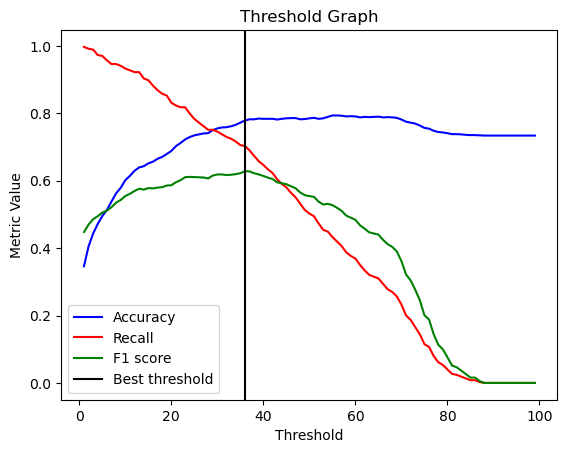

Confusion Matrix:
[[833 200]
 [111 263]]

True Positive: 263
True Negative: 833
False Positive: 200
False Negative: 111

Accuracy: 0.7789623312011372
True-Positve Rate: 0.7032085561497327
F1 score: 0.6284348864994026
Upperlimit: 0.481885625551434 Lowerlimit: 0.238114374448566
HTP: 203
notHTP: 1204
HTPTest: 203
notHTPTest: 1204


,Churn_Yes,Prob,Class
3159,0.0,0.867713,1.0
4795,1.0,0.008291,0.0
3346,0.0,0.840678,1.0
4513,1.0,0.016211,0.0
4618,0.0,0.826491,1.0


In [30]:
def hardToPredictTest(std, threshold):
    
    class0 = class0Test.copy()
    class1 = class1Test.copy()
    upperlimit = threshold + std
    lowerlimit = threshold - std
    
    print("Upperlimit:", upperlimit, "Lowerlimit:", lowerlimit)
    
    C0HP = class0[(class0["Prob"]>upperlimit)].sort_values(by="Prob", ascending = False)
    notC0Hp = class0[(class0["Prob"]<=upperlimit)]

    C1LP = class1[(class1["Prob"]<lowerlimit)].sort_values(by="Prob")
    notC1LP = class1[(class1["Prob"]>=lowerlimit)]
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        notHTP = pd.DataFrame().append(notC0Hp).append(notC1LP)
        HTP = pd.DataFrame()
        
        alternate = min(len(C0HP), len(C1LP))
        for i in range (0, alternate):
            HTP = HTP.append(C0HP.iloc[i]).append(C1LP.iloc[i])
            #print(len(orderedHTP))

        if (alternate == len(C0HP)):
            HTP = HTP.append(C1LP.iloc[(len(C0HP)):(len(C1LP))])

        else:
            HTP = HTP.append(C0HP.iloc[(len(C1LP)):(len(C0HP))])
    
    print("HTP:", len(HTP))
    print("notHTP:", len(notHTP))
    
    return (HTP, notHTP)

def evaluate(acc, pred):
    cm = confusion_matrix(acc, pred)
    print("Confusion Matrix:")
    print(cm)
    truePositive = cm[1, 1]
    trueNegative = cm[0, 0]
    falsePositive = cm[0, 1]
    falseNegative = cm[1, 0]
    print("\nTrue Positive:", truePositive)
    print("True Negative:", trueNegative)
    print("False Positive:", falsePositive)
    print("False Negative:", falseNegative)
    
    accuracy = accuracy_score(acc, pred)
    print("\nAccuracy:", accuracy)
    tpr = recall_score(acc, pred)
    print("True-Positve Rate:", tpr)
    f1 = f1_score(acc, pred)
    print("F1 score:", f1)
    
    return cm

#Training 
model = LogisticRegression(max_iter=1000)
model.fit(xtrain, ytrain)


#Getting probabilities
yprob = model.predict_proba(xtest)
thresholdTest = thresh(yprob[:, 1], ytest)
#threshold = 0.5
ypred = (yprob[:, 1] > thresholdTest).astype(int)
#Log results
evaluate(ytest,ypred)

test = xtest.copy()
test["Churn_Yes"] = ytest
test["Prob"] = yprob[:, 1]
test["Class"] = ypred

class1Test = test[test["Churn_Yes"] == 1].sort_values(by="Prob")
class0Test = test[test["Churn_Yes"] == 0].sort_values(by="Prob")

stdProbTest = .5 * test["Prob"].std()

fullHTPTest = hardToPredictTest(stdProbTest, thresholdTest)

notHTPTest = fullHTPTest[1]
HTPTest = fullHTPTest[0]

print("HTPTest:", len(HTPTest))
print("notHTPTest:", len(notHTPTest))

HTPTest[["Churn_Yes", "Prob", "Class"]].head(5)

In [31]:
upperlimit = threshold + stdProb
lowerlimit = threshold - stdProb

In [32]:
save = probdf[probdf['Prob'].between(lowerlimit, upperlimit)]

notsave = probdf.copy()
notsave = notsave.drop(save.index)

In [33]:
print(len(save))
print(len(notsave))
len(probdf)

1104
4521


5625

# Weighted Probability

In [34]:
import random
import math

In [35]:
def weightedBatches(higherWeightdf, lowerWeightdf, weightMultiplier, unitsPerBatch, v=False):
    numBatches = math.floor((len(higherWeightdf) + len(lowerWeightdf))/unitsPerBatch)
    
    high = higherWeightdf.copy()
    low = lowerWeightdf.copy()
    
    low["weight"] = 1
    high["weight"] = weightMultiplier
    
    joint = pd.concat([low, high])
    weighted = pd.DataFrame()
    
    numWeighted = []
    
    for i in range(numBatches):
        sample = joint.sample(n = unitsPerBatch, replace=False, weights='weight')
        joint = joint.drop(sample.index)
        
        numWeighted.append(len(sample[sample["weight"] == weightMultiplier]))
        weighted = pd.concat([weighted, sample])
    
    weighted = pd.concat([weighted, joint])
    
    mp = math.floor(len(numWeighted)/2)
    
    if (v):
        print("Weighted units per batch in first half:", sum(numWeighted[0:mp])/mp)

        print("Weighted units per batch in second half:", sum(numWeighted[mp:])/(len(numWeighted)-mp))
    
    return weighted.drop(["weight"], axis=1)


# Weighted Sample

In [36]:
def WNN(high, low, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])

    BCP.batch_accuracy.clear()
    BCP.batch_f1.clear()

    val_data = (xtest, ytest)

    accuracy = []
    val_accuracy = []
    f1 = []
    val_f1 = []
    epochs = range(1, 201)
    
    for i in range(200):
        df = weightedBatches(high, low, 5, 32)
        #print(df.head(1))
        xtrain = df.drop("Churn_Yes", axis=1)
        ytrain = df["Churn_Yes"]

        history = model.fit(xtrain, ytrain, epochs=1, batch_size=32, shuffle=False, 
                            validation_data=val_data, callbacks = [BCP()], verbose=0)
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        f1.append(history.history['f1_m'])
        val_f1.append(history.history['val_f1_m'])
        
    ###########
    # Plot the accuracy values
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    
    # Plot the recall values
    plt.plot(epochs, f1, 'k', label='Training f1')
    plt.plot(epochs, val_f1, 'c', label='Validation f1')

    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()
    ###########


    plt.plot(range(len(BCP.batch_f1)), BCP.batch_f1, 'r', label='F1')
    plt.title('Batch F1 Graph')
    plt.xlabel('Batch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

    print("########################   TRAIN   ########################")
    pred = model.predict(xtrain)
    threshold = thresh(pred, ytrain)
    evalNN(threshold, pred, ytrain)


    print("\n\n\n########################   TEST   ########################")
    pred = model.predict(xtest)
    evalNN(threshold, pred, ytest)

In [37]:
def perc(df, var):
    class0 = df[df["Churn_Yes"] == 0]
    class1 = df[df["Churn_Yes"] == 1]
    
    total = len(class0) + len(class1)
    zero = len(class0)/total
    one = len(class1)/total
    
    class0var0 = class0[class0[var] == 0]
    class0var1 = class0[class0[var] == 1]
    
    class1var0 = class1[class1[var] == 0]
    class1var1 = class1[class1[var] == 1]
    
    zeroZero = zero * len(class0var0)/len(class0)
    zeroOne = zero *len(class0var1)/len(class0)
    
    oneZero = one * len(class1var0)/len(class1)
    oneOne = one * len(class1var1)/len(class1)
    
    return([zeroZero, zeroOne, oneZero, oneOne])
    

In [38]:
def plotpie(df, var):
    labels = ["00", "01", "10", "11"]
    sizes = perc(df, var)
    print(sizes)
    colors = ['red', 'green', 'cyan', 'magenta']

    # Create the pie chart
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Set aspect ratio to be equal so that pie is drawn as a circle
    plt.axis('equal')

    # Add a title
    plt.title(var)

    # Display the chart
    plt.show()

# Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn import tree

In [40]:
def varImp(t, df):
    varNames = df.columns.tolist()
    
    imp = t.feature_importances_
    impDict = {}
    
    for feature, importance in zip(varNames, imp):
        impDict[feature] = importance
    
    impDF = pd.DataFrame.from_dict(impDict, orient='index', columns=['Importance'])
    
    return impDF

    

In [41]:
def dtree(x, y, xtest, ytest):
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    
    dtc.fit(x,y)
    rfc.fit(x,y)
    gbc.fit(x,y)
    
    print("--------------------Regular Tree--------------------")
    dtcimp = varImp(dtc, x)
    print(dtcimp.sort_values("Importance", ascending= False).head(5))
    yfit = dtc.predict(x)
    print("Training:")
    evaluate(y, yfit, .5)
    ypred = dtc.predict(xtest)
    print("Testomg:")
    evaluate(ytest, ypred, .5)
    
    
    print("--------------------Random Forest--------------------")
    rfcimp = varImp(rfc, x)
    print(rfcimp.sort_values("Importance", ascending= False).head(5))
    yfit = rfc.predict(x)
    ypred = rfc.predict(xtest)
    print("Training:")
    evaluate(y, yfit, .5)
    print("Testing:")
    evaluate(ytest, ypred, .5)
    
    print("--------------------Gradient Boost--------------------")
    gbcimp = varImp(gbc, x)
    print(gbcimp.sort_values("Importance", ascending= False).head(5))
    yfit = gbc.predict(x)
    ypred = gbc.predict(xtest)
    print("Training:")
    evaluate(y, yfit, .5)
    print("Testing:")
    evaluate(ytest, ypred, .5)
    
    
    
    
    

In [42]:
xColumns = list(probdf.columns)[:-3]


# Specialized models

In [43]:
def Special(df, df2, test):
    
    xColumns = list(probdf.columns)[:-3]
    
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    
    xtrain2 = df2[xColumns]
    ytrain2 = df2["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    print("\n#####################   Tree   #####################\n")
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(xtrain1,ytrain1)
    yfit = gbc.predict(xtrain1)
    ypred = gbc.predict(xtest)
    
    print("########################   TRAIN   ########################")
    evaluate(ytrain1, yfit, .5)
    print("########################   TEST   #########################")
    evaluate(ytest, ypred, .5)
    
    
    print("\n################   Neural Network   ################\n")
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])
    
    BCP.batch_accuracy.clear()
    BCP.batch_f1.clear()
    
    history = model.fit(xtrain2, ytrain2, epochs=200, batch_size=32, shuffle=True, 
                        validation_data=(xtest, ytest), callbacks = [BCP()], verbose=0)
    
    plt.plot(range(len(BCP.batch_f1)), BCP.batch_f1, 'r', label='F1')
    plt.title('Batch F1 Graph')
    plt.xlabel('Batch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()
    
    plotNN(history)
    
    print("########################   TRAIN   ########################")
    pred = model.predict(xtrain2)
    threshold = thresh(pred, ytrain2)
    evalNN(threshold, pred, ytrain2)
    
    
    print("########################   TEST   #########################")
    pred = model.predict(xtest)
    evalNN(threshold, pred, ytest)
    
    print("\n#####################   Combine   #####################\n")
    
    
    ypred = gbc.predict_proba(xtest)[:,1]
    
    combine =  [max(x, y, key=lambda num: abs(num - 50)) for x, y in zip(list(pred), list(ypred))]
    
    evalNN(threshold, combine, ytest)
    
    

In [44]:
test = xtest.copy()
test["Churn_Yes"]= ytest

In [45]:
#Special(HTP, notHTP, test)

In [46]:
def Triple(df, df2, df3, test):
    
    xColumns = list(probdf.columns)[:-3]
    
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    
    xtrain2 = df2[xColumns]
    ytrain2 = df2["Churn_Yes"]
    
    xtrain3 = df3[xColumns]
    ytrain3 = df3["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    

    pred1 = SGB(xtrain1, ytrain1, xtest, ytest)

    
    pred2 = SNN(xtrain2, ytrain2, xtest, ytest)

    
    pred3 = SNN(xtrain3, ytrain3, xtest, ytest)

    
    print("\n#####################   Combine   #####################\n")
    
    preddf = pd.DataFrame()
    preddf["p1"] = pred1
    preddf["p2"] = pred2
    preddf["p3"] = pred3
    
    preddf.loc[preddf["p1"] + preddf["p2"] + preddf["p3"]>= 2, 'final'] = 1
    preddf.loc[preddf["p1"] + preddf["p2"] + preddf["p3"] < 2, 'final'] = 0
    
    evaluate(ytest, preddf["final"], "n/a")

In [47]:
def SNN(x, y, xt, yt):
    print("\n########################   Neural Network   ########################")
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])
    
    history = model.fit(x, y, epochs=200, batch_size=32, shuffle=True, 
                        validation_data=(xt, yt), verbose=0)
    
    plotNN(history)
    
    print("########################   TRAIN   ########################")
    pred = model.predict(xt)
    threshold = thresh(pred, yt)
    evalNN(threshold, pred, yt)
    
    print("########################   TEST   #########################")
    pred = model.predict(xt)
    evalNN(threshold, pred, yt)
    classPred = [0 if val < threshold else 1 for val in pred]
    
    return (classPred)

def SGB(x, y, xt, yt):
    print("\n#####################   Tree   #####################\n")
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(x,y)
    yfit = gbc.predict(x)
    ypred = gbc.predict(xt)
    
    print("########################   TRAIN   ########################")
    evaluate(y, yfit, .5)
    print("########################   TEST   #########################")
    evaluate(yt, ypred, .5)
    
    return (ypred)
    

In [48]:
#Triple(HTP, notHTP, probdf, test)

# Different prob

In [49]:
def thresh(pred, ytest):
    bestf1 = 0
    bestthresh = 0
    
    for i in range(1,100):
        classPred = [0 if val < (i/100) else 1 for val in pred]
        f1 = f1_score(ytest, classPred)
        #print(f1)
        if (f1>bestf1):
            bestf1 = f1
            bestthresh=i
            
    return (bestthresh/100)

In [50]:
def mm(x, y, xt, tx, yt):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])
    
    model.fit(x, y, epochs=200, batch_size=32, shuffle=True, verbose=0)
    
    ypred = model.predict(xt)
    test = model.predict(tx)
    
    bestT = thresh(ypred, yt)
    
    return([ypred, test, model, bestT])

def mt(x, y, xt, tx):
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(x,y)
    ypred = gbc.predict_proba(xt)[:,1]
    test = gbc.predict_proba(tx)[:,1]
    
    return ([ypred, test, gbc])
    

def mdp(df, p, p2):
    ptotal = df.copy()
    ptotal["Tree"] = p
    ptotal["NN"] = p2
    ptotal["Diff"] = abs(ptotal["Tree"] - ptotal["NN"])
    
    DP = ptotal[ptotal["Diff"] >= .5]
    nDP = ptotal[ptotal["Diff"] <= .5]
    
    dpx = DP[xColumns]
    
    dpy = DP["Churn_Yes"]
    
    ndpx = nDP[xColumns]
    
    ndpy = nDP["Churn_Yes"]
    
    return (dpx, dpy, ndpx, ndpy)

In [51]:
def Triple(df, df2, total, test):
    
    xColumns = list(probdf.columns)[:-3]
    
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    
    xtrain2 = df2[xColumns]
    ytrain2 = df2["Churn_Yes"]
    
    xtotal = total[xColumns]
    ytotal = total["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    tp = mt(xtrain1, ytrain1, xtotal, xtest)
    nnp = mm(xtrain2, ytrain2, xtotal, xtest, ytotal)
    
    dptrain = mdp(total, tp[0], nnp[0])
    
    dptest = mdp(test, tp[1], nnp[1])
    
    dpn = mm(dptrain[0], dptrain[1], dptest[0], dptest[0], dptest[1])
    
    bestT = thresh(dpn[1], dptest[1])
    
    classPred = [0 if val < bestT else 1 for val in dpn[1]]
    
    evaluate(dptest[1], classPred)
    
    pred = tp[2].predict_proba(dptest[2])[:,1]
    ypred = nnp[2].predict(dptest[2])
    
    combine =  [max(x, y, key=lambda num: abs(num - 50)) for x, y in zip(list(pred), list(ypred))]
    
    evalNN(.65, combine, dptest[3])

36/36 [==============================] - 0s 806us/step
Confusion Matrix:
[[746 118]
 [ 91 188]]

True Positive: 188
True Negative: 746
False Positive: 118
False Negative: 91

Accuracy: 0.8171478565179353
True-Positve Rate: 0.6738351254480287
F1 score: 0.6427350427350427
9/9 [==============================] - 0s 874us/step


C:\Users\21sla\anaconda3\lib\site-packages\sklearn\utils\_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)
C:\Users\21sla\anaconda3\lib\site-packages\sklearn\utils\_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


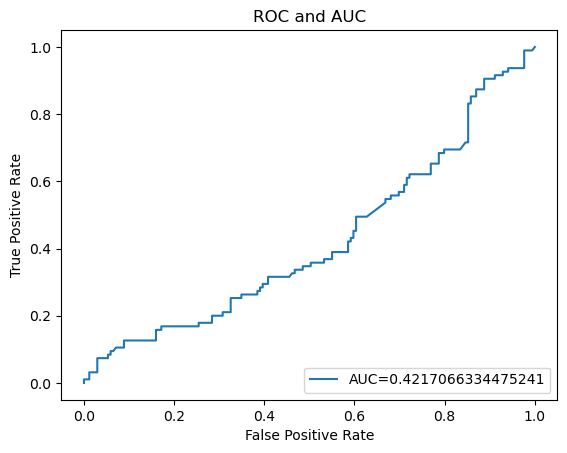

Confusion Matrix:
[[169   0]
 [ 95   0]]

True Positive: 0
True Negative: 169
False Positive: 0
False Negative: 95

Accuracy: 0.6401515151515151
True-Positve Rate: 0.0
F1 score: 0.0


In [114]:
Triple(HTP, notHTP, probdf, test)

# Cluster

In [52]:
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import KNeighborsClassifier

In [54]:
# Combine the encoded categorical variables and numerical variables into a single feature matrix
X = probdf[xColumns]

# Perform k-medoids clustering
k = 2  # Number of clusters
kmedoids = KMedoids(n_clusters=k)
kmedoids.fit(X)

# Get the cluster assignments and medoid indices
labels = kmedoids.labels_
medoid_indices = kmedoids.medoid_indices_

# Print the cluster labels and medoid indices
print("Cluster Labels:", labels)
print("Medoid Indices:", medoid_indices)

#new_labels = kmedoids.predict(new_samples)


Cluster Labels: [1 1 0 ... 1 1 1]
Medoid Indices: [2814 3415]


In [55]:
print(len(kmedoids.labels_))

5625


In [53]:
def cluster (df, df2, test):
    xColumns = list(probdf.columns)[:-3]
    
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    
    xtrain2 = df2[xColumns]
    ytrain2 = df2["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    k1 = KNeighborsClassifier(n_neighbors=3)

    k1.fit(xtrain1)
    
    k2 = KNeighborsClassifier(n_neighbors=3)

    k2.fit(xtrain2)
    
    d1 = k1.transform(xtest)
    
    d2 = k2.transform(xtest)
    
    clusterdf = test.copy()
    clusterdf["d1"] = d1
    clusterdf["d2"] = d2
    clusterdf["HTP"] = 0
    
    k1test = clusterdf[clusterdf["d1"] < clusterdf["d2"]]
    clusterdf.loc[clusterdf["d1"] < clusterdf["d2"], 'HTP'] = 1
    #print(clusterdf)
    
    print("Predicted HTPTest:", len(k1test))
    print("Acutal HTPTest:", len(HTPTest))
    
    k2test = clusterdf[clusterdf["d1"] >= clusterdf["d2"]]
    
    print("Predicted notHTPTest:", len(k2test))
    print("Acutal notHTPTest:", len(notHTPTest))
    
    return ([clusterdf, k1test, k2test])

In [54]:
tot = cluster(HTP, notHTP, test)
pDF = tot[0]



TypeError: KNeighborsClassifier.fit() missing 1 required positional argument: 'y'

In [92]:
aDF = test.copy()

In [93]:
aDF["HTP"] = 0

In [97]:
aDF.loc[HTPTest.index, 'HTP'] = 1

In [100]:
evaluate(aDF["HTP"], pDF["HTP"])

Confusion Matrix:
[[674 530]
 [104  99]]

True Positive: 99
True Negative: 674
False Positive: 530
False Negative: 104

Accuracy: 0.5493958777540867
True-Positve Rate: 0.4876847290640394
F1 score: 0.23798076923076925


array([[674, 530],
       [104,  99]], dtype=int64)

In [43]:
def NN(df, xtest, ytest, t2=False, bo = False):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])

    
    xtrain = df.drop("Churn_Yes", axis=1)
    ytrain = df["Churn_Yes"]
    
    print("Starting Model Training")
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
    print("Model Training Finished")
    
    if (bo):
        yprob = model.predict(t2.drop(["Class", "Prob", "Churn_Yes"], axis = 1))
        print("NN", yprob[0], "acutal", t2["Churn_Yes"].head(1))
        # Create a scatter plot
        plt.scatter(yprob, t2.index, c=t2["Churn_Yes"], cmap='viridis')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Sample Unit')
        plt.title('Predicted Probabilities and Class Labels')
        plt.show()
        
    print("Training ROC:")
    pred = model.predict(xtrain)
    
    #print(pred)
    plotROC(pred, ytrain)
    #plotNN(history)
    return(evalNN(model, xtest, ytest))

def evaluate(acc, pred):
    cm = confusion_matrix(acc, pred)
    print("Confusion Matrix:")
    print(cm)
    truePositive = cm[1, 1]
    trueNegative = cm[0, 0]
    falsePositive = cm[0, 1]
    falseNegative = cm[1, 0]
    print("\nTrue Positive:", truePositive)
    print("True Negative:", trueNegative)
    print("False Positive:", falsePositive)
    print("False Negative:", falseNegative)
    
    accuracy = accuracy_score(acc, pred)
    print("\nAccuracy:", accuracy)
    tpr = recall_score(acc, pred)
    print("True-Positve Rate:", tpr)
    f1 = f1_score(acc, pred)
    print("F1 score:", f1)
    
    return cm

def evaluateCM(cm):
    print("\nTotal Confusion Matrix:")
    print(cm)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Calculate precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\nAccuracy:", accuracy)
    print("True-Positve Rate:", recall)
    print("F1 score:", f1)

def evalNN(model, xtest, ytest):
    pred = model.predict(xtest)
    # Plot the histogram
    print("Test ROC:")
    plotROC(pred, ytest)
    bestThresh = thresh(pred, ytest)
    classPred = [0 if val < bestThresh else 1 for val in pred]
    return(evaluate(ytest, classPred))

def NN2(df, df2, test, test2):
    
    df = df.drop(["Class", "Prob"], axis =1)
    len(df)
    xt = test.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt = test["Churn_Yes"]
    len(yt)

    NN1CM = NN(df, xt, yt)
    
    df2 = df2.drop(["Class", "Prob"], axis =1)
    len(df2)
    xt2 = test2.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt2 = test2["Churn_Yes"]
    len(yt)
    
    NN2CM = NN(df2, xt2, yt2)
    
    return (evaluateCM(NN1CM+NN2CM))

def NNTree(df, df2, test, test2):
    
    df = df.drop(["Class", "Prob"], axis =1)
    xt = test.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    yt = test["Churn_Yes"]

    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(df.drop(["Churn_Yes"], axis=1),df["Churn_Yes"])
    ypred = gbc.predict(xt)
    NN1CM = evaluate(yt, ypred)
    
    df2 = df2.drop(["Class", "Prob"], axis =1)
    len(df2)
    xt2 = test2.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt2 = test2["Churn_Yes"]
    len(yt)
    
    predict = pd.concat([test, test2])
    yprob = gbc.predict_proba(predict.drop(["Churn_Yes", "Class", "Prob"], axis = 1))
    print("tree", yprob[:, 1][0], "acutal", predict["Churn_Yes"].head(1))
    # Create a scatter plot
    plt.scatter(yprob[:, 1], predict.index, c=predict["Churn_Yes"], cmap='viridis')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Sample Unit')
    plt.title('Predicted Probabilities and Class Labels')
    plt.show()
    
    NN2CM = NN(df2, xt2, yt2, predict, True)
    
    return (evaluateCM(NN1CM+NN2CM))


Confusion Matrix:
[[126 274]
 [188  41]]

True Positive: 41
True Negative: 126
False Positive: 274
False Negative: 188

Accuracy: 0.2655007949125596
True-Positve Rate: 0.17903930131004367
F1 score: 0.15073529411764708
tree 0.9883786283874788 acutal 6784    0
Name: Churn_Yes, dtype: uint8


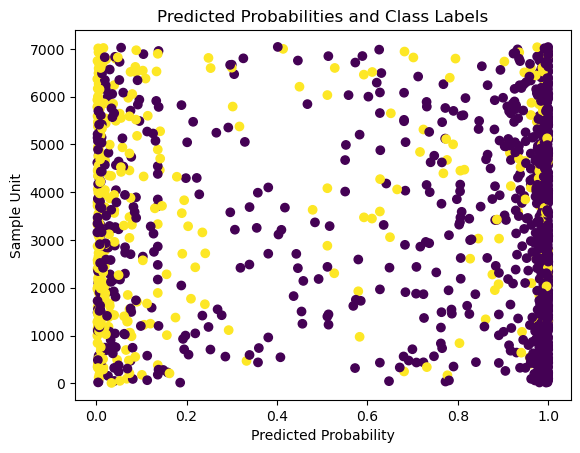

Starting Model Training
Model Training Finished
44/44 [==============================] - 0s 663us/step
NN [0.00050782] acutal 6784    0
Name: Churn_Yes, dtype: uint8


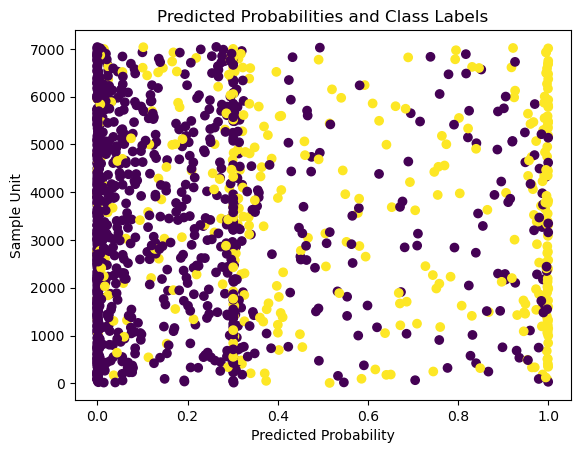

Training ROC:
154/154 [==============================] - 0s 862us/step


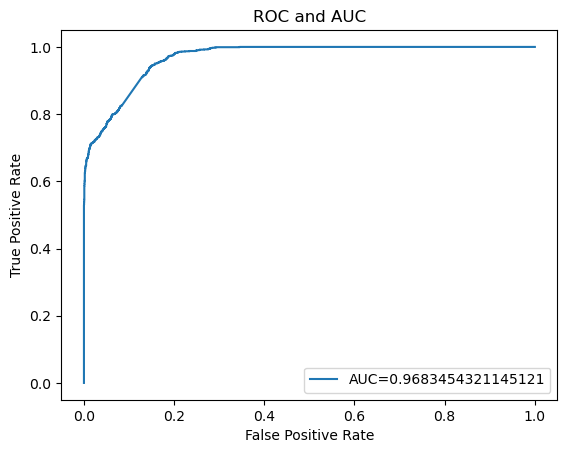

25/25 [==============================] - 0s 1ms/step
Test ROC:


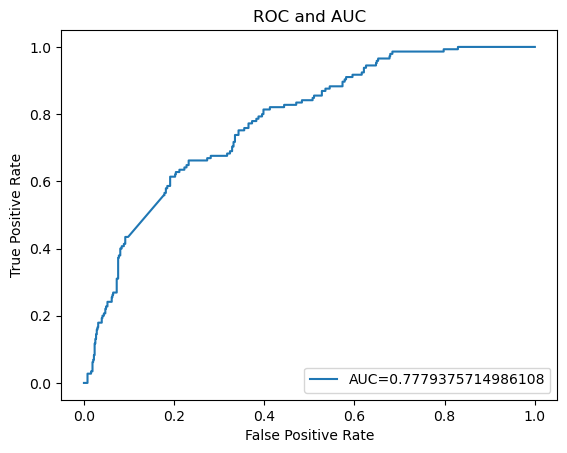

Confusion Matrix:
[[512 121]
 [ 57  88]]

True Positive: 88
True Negative: 512
False Positive: 121
False Negative: 57

Accuracy: 0.7712082262210797
True-Positve Rate: 0.6068965517241379
F1 score: 0.4971751412429379

Total Confusion Matrix:
[[638 395]
 [245 129]]

Accuracy: 0.5451314854299929
True-Positve Rate: 0.3449197860962567
F1 score: 0.2873051224944321


In [111]:
NNTree(HTP, notHTP, tot[1].drop(["HTP", "d1", "d2"], axis=1), tot[2].drop(["HTP", "d1", "d2"], axis=1))